# Netflix recommender system

In this notebook, we will build a neural network capable of recommending movies to Netlix users, based on their viewing history.   

The [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) was an open competition which began in 2006. The goal for the competition was to build an algorithm capable of predicting user ratings for films, using nothing other than the users' viewing history (i.e. no personal information).   

The prize money for the competition was US$1 000 000, and was won by the BellKor's Pragmatic Chaos team in 2009, with a score of 0.8567 on the test set.   

The full data set is available on Kaggle [here](https://www.kaggle.com/netflix-inc/netflix-prize-data).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

path='../data/'

/home/james/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Defining the model
We are going to use our own custom neural network to learn the user and movie embeddings.   

This neural network will be pretty simple, with the input being simply a user-movie pair, and the output being a predicted rating.   
Between the input and the output, we have two layers:
 - embedding layer (with dropout)
 - hidden layer (with dropout and relu activation function)   
 
![NN diagram](https://raw.githubusercontent.com/James-Leslie/Netflix-Recommender-System/blob/master/diagrams/EmbeddingNet.pdf)

The model is defined below as a standard PyTorch model.

In [2]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10)  # 10 hidden layers
        self.lin2 = nn.Linear(10, 1)
        self.drop1 = nn.Dropout(0.05)  # dropout rate of 0.05
        self.drop2 = nn.Dropout(0.5)  # dropout rate of 0.5

    def forward(self, users, items):
        x = self.drop1(torch.cat([self.u(users),self.i(items)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.lin2(x)
        return F.sigmoid(x) * (self.max_score-self.min_score) + self.min_score

Now we need to extend the `CollabFilterDataset` class (source code is found in `fastai/column_data.py`) so that it uses our `EmbeddingNet` model rather than the `EmbeddingDotBias` model used by the default class.

In [3]:
class RecommenderNetDataset(CollabFilterDataset):
    
    # this class will inherit all methods of the parent class
    def __init__(self, path, user_col, item_col, ratings):
        super().__init__(path, user_col, item_col, ratings)
    
    # and now we will add two other methods to the class
    def get_nn_model(self, n_factors):
        model = EmbeddingNet(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))
    
    # the model will be a PyTorch model, with all of the additional fastai methods added on
    def get_deep_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_nn_model(n_factors), **kwargs)

In [4]:
# load the data
rs = RecommenderNetDataset.from_csv(path, 'data_1_long.csv', 'Cust_Id', 'Movie_Id', 'Rating')

In [6]:
val_idxs = get_cv_idxs(rs.n)
n_factors = 5
batch_size = 256

In [7]:
learn = rs.get_deep_learner(n_factors, val_idxs, batch_size, opt_fn=optim.Adam)

In [8]:
lrf = learn.lr_find()

 93%|█████████▎| 39112/42277 [02:19<00:11, 281.23it/s, loss=3.53]

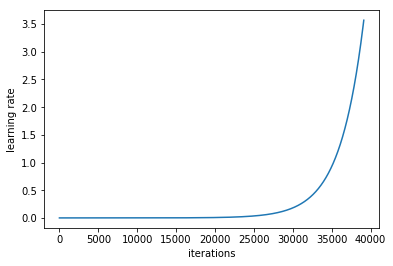

In [9]:
learn.sched.plot_lr()

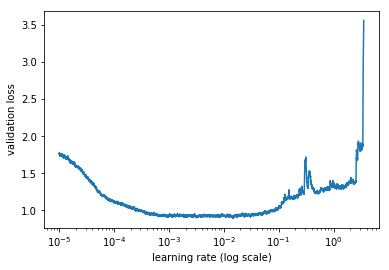

In [10]:
learn.sched.plot()

In [2]:
cf = CollabFilterDataset.from_csv(path, 'data_1_long.csv', 'Cust_Id', 'Movie_Id', 'Rating')

In [3]:
val_idxs = get_cv_idxs(cf.n)
n_factors = 5
batch_size = 256

Inside the fastai source code (`fastai/column_data.py`), you will find the definition of the `EmbeddingDotBias` model.

I have gone and edited the fastai source code. The `get_learner()` function below now makes use of the `EmbeddingNet` model rather than the `EmbeddingDotBias` model used on the movielens data.

In [4]:
learn = cf.get_learner(n_factors, val_idxs, batch_size, opt_fn=optim.Adam)

Let's find out what learning rate we should use.

In [5]:
lrf=learn.lr_find()

 92%|█████████▏| 38901/42277 [02:21<00:12, 275.85it/s, loss=3.51]

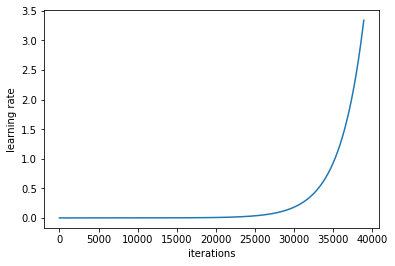

In [6]:
learn.sched.plot_lr()

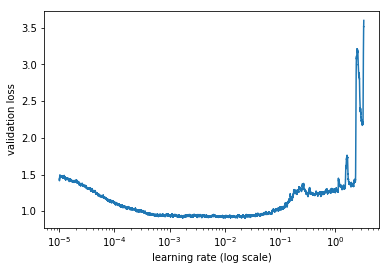

In [7]:
learn.sched.plot()

In [8]:
learn.fit(1e-3, 1)

epoch      trn_loss   val_loss   
    0      0.854802   0.824823  


[array([0.82482])]

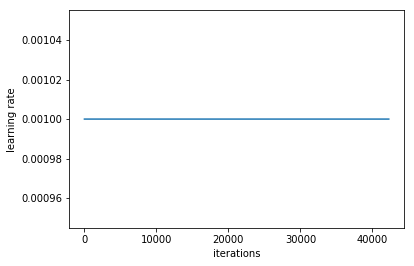

In [9]:
learn.sched.plot_lr()

As we can see, the learning rate remained constant throughout the training process.   

We would rather decrease the learning rate as training progresses (initially update the values by large amounts, then update by smaller amounts as we get closer to the optimum values).   

In [10]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   
    0      0.851836   0.812047  
    1      0.838179   0.809101  
    2      0.835316   0.807573  


[array([0.80757])]

In [ ]:
learn.sched.plot_lr()

In [5]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.888731   0.835163  
    1      0.858942   0.813219  
    2      0.849319   0.808653  



[array([0.80865])]

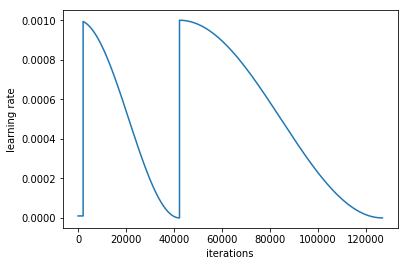

In [6]:
learn.sched.plot_lr()

## Regularization
Try and find the right value for the `wd` (weight decay) parameter below.

In [7]:
wd = 1e-6

In [8]:
learn.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.850382   0.809184  
    1      0.843988   0.809002  
    2      0.855662   0.805702  



[array([0.8057])]